## 1. 구글 드라이브 마운트

구글 드라이브를 마운트해야 구글 드라이브에 yolo 코드를 다운받고, 드라이브에 있는 데이터로 학습을 할 수 있음

In [1]:
from google.colab import drive
import os 

drive.mount('/content/drive/') 

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
# 작업 경로를 MyDrive로 변경하여 구글 드라이브에 접속 후 바로 작업 디렉토리를 확인 가능

print('현재 작업 경로 :', os.getcwd())
os.chdir('/content/drive/MyDrive')
print('변경된 작업 경로 :', os.getcwd())

현재 작업 경로 : /content
변경된 작업 경로 : /content/drive/MyDrive


## 2. YOLOv5 레퍼지토리 다운로드
코드를 실행하면 구글 드라이브에 YOLO 코드가 다운로드
한 번만 다운로드하면 됨(구글 드라이브에 다운로드되니까)


In [3]:
# 처음에 한번만 실행 !
!git clone https://github.com/ultralytics/yolov5  # YOLOv5 레퍼지토리 clone

'git'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [4]:
# 필요한 패키지 다운로드 및 임포트
%cd yolov5
%pip install -qr requirements.txt # |install dependencies
%pip install -q roboflow

import torch
import yaml
from IPython.display import Image, clear_output  # to display images

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

[WinError 2] 지정된 파일을 찾을 수 없습니다: 'yolov5'
c:\Users\deka2\OneDrive\Desktop\plant_disease.v2i.yolov5pytorch
Note: you may need to restart the kernel to use updated packages.


'install'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


Note: you may need to restart the kernel to use updated packages.
Setup complete. Using torch 2.0.1+cpu (CPU)


## 3. 데이터셋 다운로드, yaml 파일 수정 - 각자 진행
- 사용하고자 하는 커스텀 데이터셋을 구글 드라이브에 'dataset'이라는 폴더에 업로드
- 'dataset' 폴더 안에는 학습/평가 데이터와 어노테이션(라벨) 그리고 데이터셋에 대한 설명이 담긴 yaml파일 필요

- Roboflow의 퍼블릭 데이터셋 사용
  - [roboflow 퍼블릭 데이터셋](https://public.roboflow.com/object-detection)에서 사용하고 싶은 데이터셋 다운로드해서 해당 폴더에 업로드
  - 여러 포맷으로 다운로드할 수 있는데 그 중에서 TXT - YOLOv5 PyTorch 로 다운로드

- 그 외 커스텀 데이터셋 사용
  - 다른 데이터셋이나 본인이 만든 데이터셋을 사용하고 싶다면 데이터, 라벨, yaml 파일을 모두 퍼블릭 데이터셋의 규격에 맞게 통일해줘야됨 (물론 코드 수정이 가능하다면 데이터셋 로딩하는 코드를 수정해도 됨)

- yaml 파일 수정 
  - train, val(또는 test) 데이터가 있는 경로 수정 필요




In [5]:
# 사용할 데이터셋 경로 및 데이터셋의 yaml 파일 경로 지정
data_dir = '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch'
data_yaml = '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch/data.yaml'

In [6]:
# 데이터셋 yaml 파일 확인 
with open(data_yaml) as f:
    film = yaml.load(f, Loader=yaml.FullLoader)
    display(film)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch/data.yaml'

In [ ]:
# yaml 파일의 train, val 데이터가 있는 경로 수정 (기존 경로 -> 구글 드라이브에 저장된 경로로)
film['train'] = '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch/train/images'
film['val'] = '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch/test/images'

with open(data_yaml, 'w') as f:
    yaml.dump(film, f)

print('변경된 yaml 파일 :')
with open(data_yaml) as f:
    film = yaml.load(f, Loader=yaml.FullLoader)
    display(film)

변경된 yaml 파일 :


{'names': ['Blight'],
 'nc': 1,
 'roboflow': {'license': 'CC BY 4.0',
  'project': 'leaf-disease-detection-soqm2',
  'url': 'https://universe.roboflow.com/school-gapdh/leaf-disease-detection-soqm2/dataset/5',
  'version': 5,
  'workspace': 'school-gapdh'},
 'test': '../test/images',
 'train': '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch/train/images',
 'val': '/content/drive/MyDrive/dataset/Leaf_Disease_Detection.v5i.yolov5pytorch/test/images'}

# 4. YOLOv5 모델 학습
- 배치사이즈, 학습 에폭, 모델 사이즈 등을 선택하여 학습시킬 수 있음
- 학습 결과 중 베스트 모델이 저장됨 -> 모델 저장된 경로 확인 필수!
  - img: 입력 이미지 크기
  - batch: 배치 사이즈
  - epochs: 총 학습 에폭
  - data: 데이터셋 yaml 파일 경로
  - weights: 모델 웨이트 경로(pre-train된 모델로 학습시키기 때문에)
  - cache: 캐시 이미지

In [2]:
!python train.py --img 416 --batch 16 --epochs 200 --data {data_yaml} --weights yolov5s.pt --cache

python: can't open file 'train.py': [Errno 2] No such file or directory


# 5. 텐서보드 시작하기
텐서보드는 학습시키는 딥러닝 모델이 잘 학습되는지 시각적으로 확인할 수 있는 어플리케이션이라보 보시면 좋을 것 같습니다.

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

# 6. 학습한 모델 테스트

In [ ]:
# 테스트 이미지 경로
test_data_dir = film['val']

# 실험 번호 지정 - 진행한 실험이 저장된 경로 확인해서 기입! - runs/train/exp1 인지 exp2, exp3 인지 확인 후 아래 번호 지정
train_exp_num = 2

In [ ]:
!python detect.py --weights runs/train/exp{train_exp_num}/weights/best.pt --img 416 --conf 0.1 --source {test_data_dir}

detect: weights=['runs/train/exp2/weights/best.pt'], source=/content/drive/MyDrive/dataset/cochineal_cactus.v3-3try.yolov5pytorch/test/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
requirements: /usr/local/lib/python3.10/dist-packages/requirements.txt not found, check failed.
YOLOv5 🚀 v7.0-168-gec2b853 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/4 /content/drive/MyDrive/dataset/cochineal_cactus.v3-3try.yolov5pytorch/test/images/-3-_jpeg.rf.7cabefb50c27d85f4a348073b26e6fbc.jpg: 416x416 1 NOK, 2 OKs, 7.4ms
image 2/4 /content

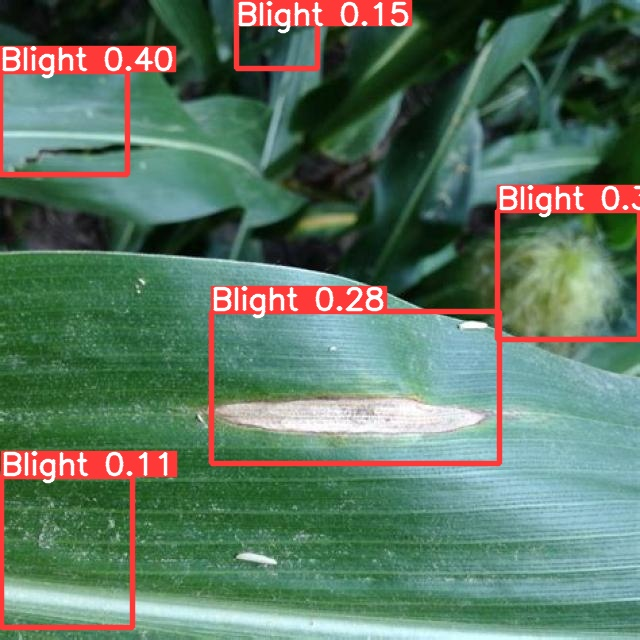

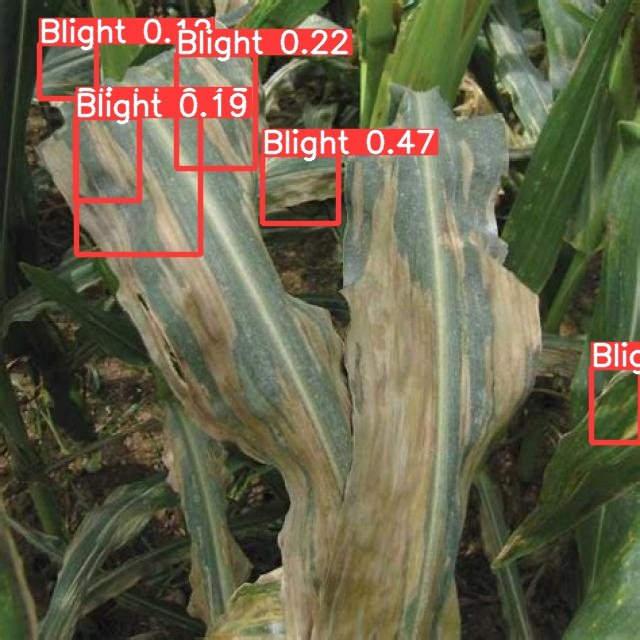

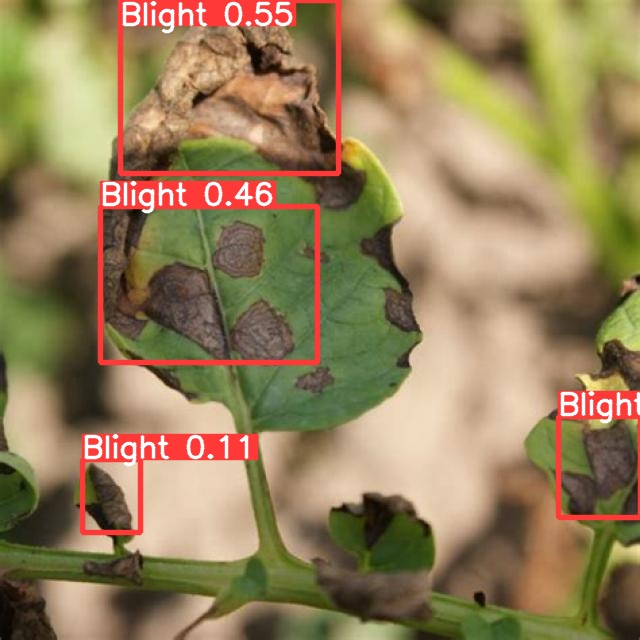

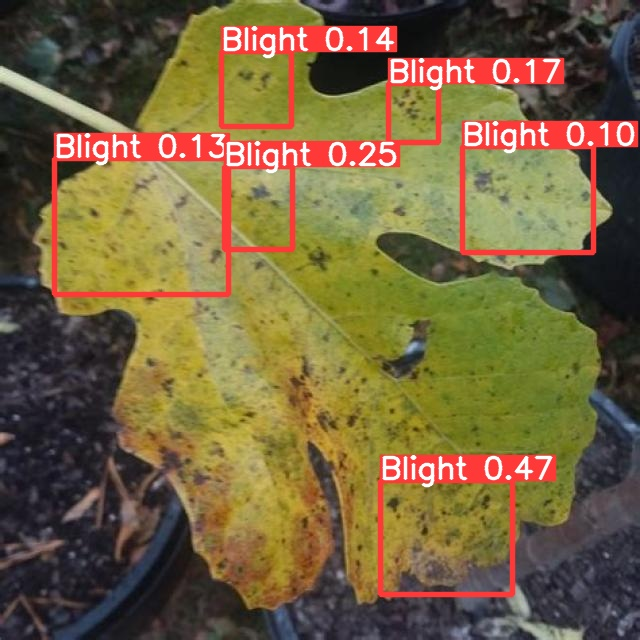

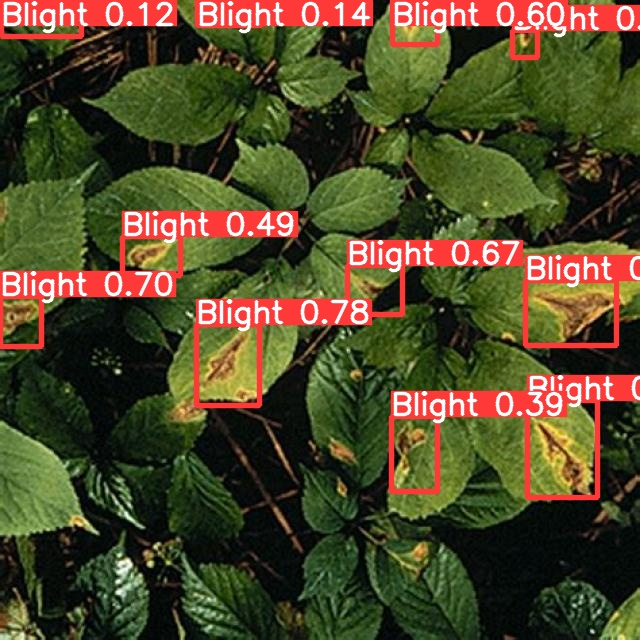

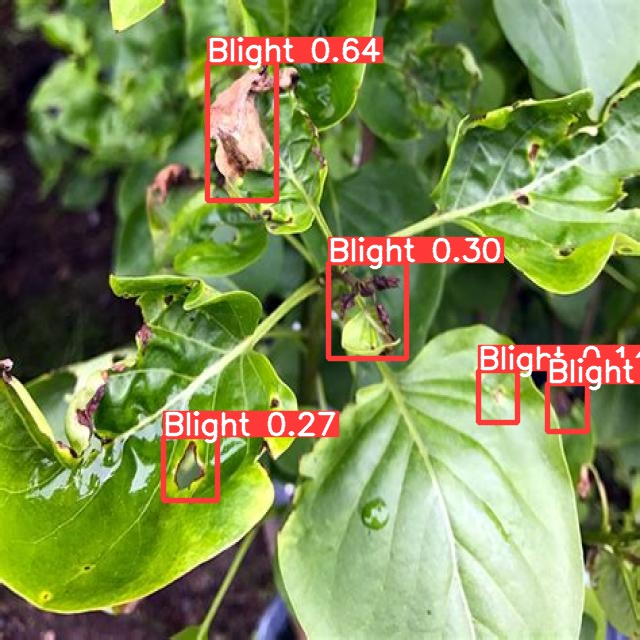

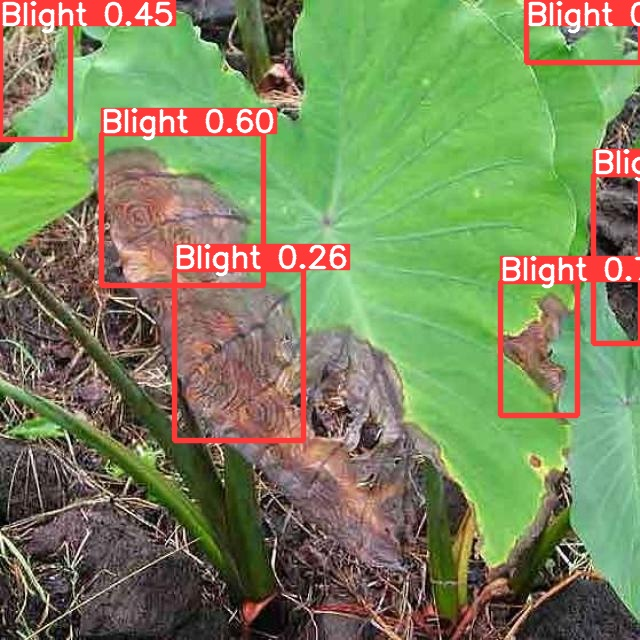

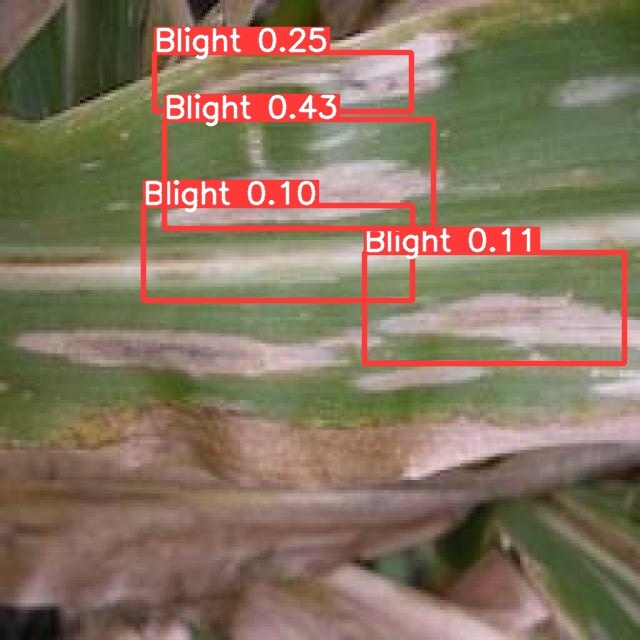

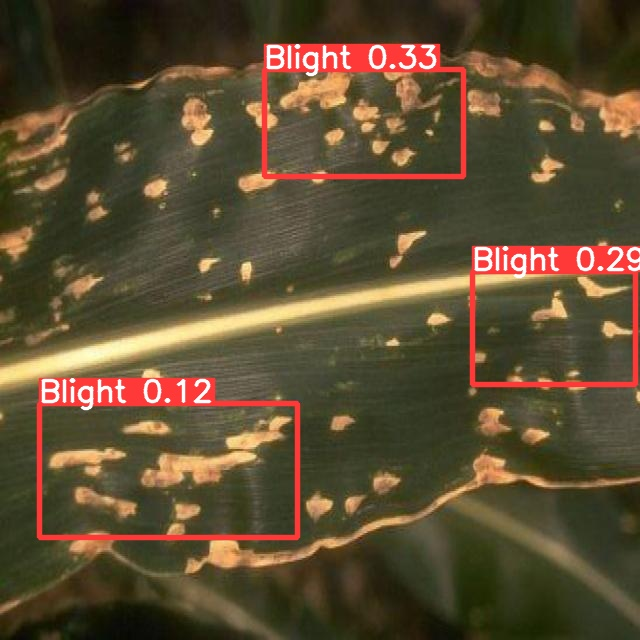

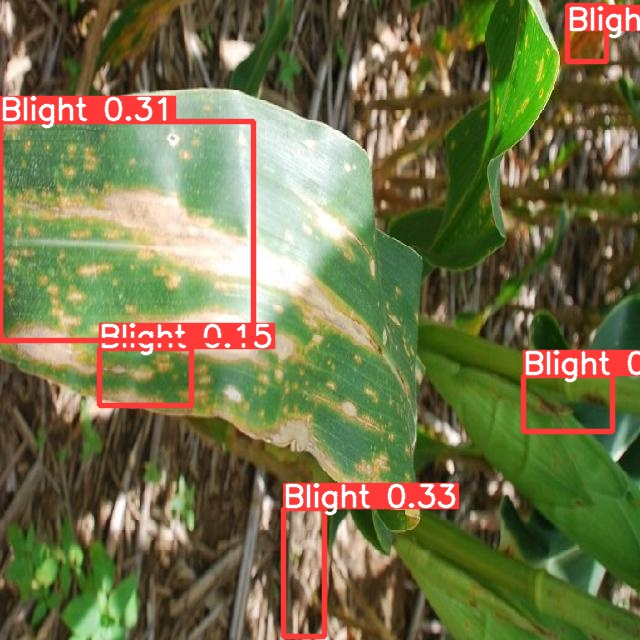

In [ ]:
# 테스트 결과 확인해보기

import glob
from IPython.display import Image, display

test_exp_num = 2

if not os.path.exists('/content/drive/MyDrive/yolov5/runs/detect/exp' + str(test_exp_num) + '/') :
  raise Exception('test_exp_num 을 다시 확인하세요.')

for imageName in glob.glob('/content/drive/MyDrive/yolov5/runs/detect/exp' + str(test_exp_num) + '/*.jpg'): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

## 7. 학습한 베스트 모델 저장

In [ ]:
# 학습한 베스트 모델 저장
from google.colab import files
files.download('./runs/train/exp' + str(test_exp_num) + '/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>